# Projet Fixmatch

In [2]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [3]:

# system
import sys
sys.path.append('..')

# data
import numpy as np

# deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# torchvision
import torchvision

# plotting
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# utils and model
from utils.utils import (
    seedEverything,
    compute_mean_std,
    data_transform,
    normalize,
    plot_images,
)

from utils.model import ConvNN
from typing import List

# FIXMATCH
from fixmatch import fixmatch_train

# os
import os
import path

# sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics.pairwise import pairwise_distances

%load_ext autoreload
%autoreload 2

In [4]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [5]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [6]:
# Download both datasets
trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=data_transform())
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=data_transform())

# convert to data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# compute mean and std
if not os.path.exists('../data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, '../data/mean.pt')
    torch.save(std, '../data/std.pt')
else:
    mean, std = torch.load('../data/mean.pt'), torch.load('../data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")

mean: [0.49142736 0.48217902 0.4465423 ], std: [0.24636985 0.24283184 0.26074585]


In [8]:
# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [9]:
torch_models = './results/models/' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

In [10]:
# load full model
model_full = ConvNN(return_features=True).to(device)
model_full.load_state_dict(torch.load(f'../SUP/results/models/model_100.pth'))

<All keys matched successfully>

## IV. Semi-Supervised Learning: Fixmatch with KMeans Clustering on feature space

### IV.0 KMeans clustering

In [11]:
def perform_spectral_clustering(
        model_full: ConvNN,
        trainloader: torch.utils.data.DataLoader,
        budget: float = 0.01
        ) -> np.ndarray:

    # Compute the output embeddings from the model
    print("Extracting embeddings from the model")
    embeddings = []
    pbar = tqdm(trainloader, total=len(trainloader))
    for i, (train_data) in enumerate(pbar):
        images, _ = train_data
        images = normalize(mean, std)(images)
        images = images.to(device)

        # Forward pass
        outputs = model_full(images).detach().cpu().numpy()
        embeddings.append(outputs)

    # Stack the embeddings
    embeddings_array = np.vstack(embeddings)

    # Compute pairwise distance matrix
    # pairwise_distances_matrix = pairwise_distances(embeddings_array)

    # Perform KMeans clustering
    print("Performing KMeans clustering")
    kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings_array)


    # Perform spectral clustering
    # spectral_clustering = SpectralClustering(
    #     n_clusters=10, affinity='rbf', assign_labels='discretize', verbose=True
    # )
    # spectral_clustering.fit(pairwise_distances_matrix)

    # Obtain the cluster labels
    cluster_labels = kmeans.labels_

    # Compute the cluster centers
    print("Computing cluster centers")
    cluster_centers = []
    for cluster_i in range(10):
        cluster_i_indices = np.where(cluster_labels == cluster_i)[0]
        cluster_i_embeddings = embeddings_array[cluster_i_indices]
        cluster_i_center = np.mean(cluster_i_embeddings, axis=0)
        cluster_centers.append(cluster_i_center)

    cluster_centers = np.vstack(cluster_centers)

    # Compute the distance between each data point and cluster centers
    distances = pairwise_distances(embeddings_array, cluster_centers)

    # Filter distance to closest cluster center according to prediction
    distances_filtered = np.array(
        [distances[i, cluster_labels[i]] for i in range(len(cluster_labels))]
    )

    # Show histogram and horizontal lines indicating X% of the data
    plt.hist(distances_filtered, bins=100)
    plt.axvline(np.percentile(distances_filtered, 90), color='red', label='90%')
    plt.axvline(np.percentile(distances_filtered, 95), color='blue', label='95%')
    plt.axvline(np.percentile(distances_filtered, 99), color='green', label='99%')
    plt.xlabel('Distance to assigned cluster center')
    plt.ylabel('Number of data points')
    plt.title('Histogram of distances to assigned cluster center')
    plt.legend()
    plt.show()

    # Select the top budget fraction of samples closest to their assigned cluster centers
    # indices = np.argsort(distances_filtered)[:int(budget * len(distances_filtered))]

    # select half of the samples close to their assigned cluster centers and half of the samples far from their assigned cluster centers
    # indices_1 = np.argsort(distances_filtered)[int(budget * len(distances_filtered) / 2):int(budget * len(distances_filtered))]
    indices_2 = np.argsort(distances_filtered)[:int(budget * len(distances_filtered))]

    # concatenate
    # indices = np.concatenate((indices_1, indices_2))
    indices = indices_2

    # save clusters
    torch.save(cluster_labels, f'./results/clustering/clusters.pth')
    torch.save(distances_filtered, f'./results/clustering/distances_filtered.pth')
    torch.save(indices, f'./results/clustering/indices_{int(budget*100)}.pth')


    return indices

### IV.1 Fixmatch on 10% train data with KMeans Clustering 

Extracting embeddings from the model


  0%|          | 0/782 [00:00<?, ?it/s]

Performing KMeans clustering


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Computing cluster centers


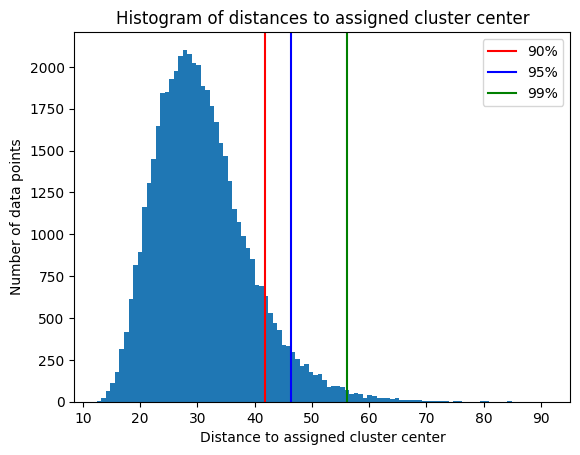

In [30]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.10

# load indices
indices_10 = perform_spectral_clustering(model_full, trainloader, budget=0.10)

In [31]:
trainset_sup = torch.utils.data.Subset(trainset, indices_10)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [32]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [33]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='10_KMEANS'
)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 23.72%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 33.1%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 39.66%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 34.15%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 44.21%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 48.55%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.1%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 46.21%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.49%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 51.63%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.32%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.19%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.84%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.23%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.68%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.81%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.27%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.25%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.56%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.63%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.28%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.7%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 63.92%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.47%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.12%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 62.94%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.6%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.75%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.92%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 64.78%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.83%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.04%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 65.84%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 66.07%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.04%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.08%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.78%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.21%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.4%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.84%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 67.27%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.33%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.3%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.49%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.05%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.12%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.34%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.35%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.83%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.71%


Epoch    50:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.47%


Epoch    51:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.35%


Epoch    52:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.31%


Epoch    53:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.06%


Epoch    54:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.83%


Epoch    55:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.69%


Epoch    56:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 68.64%


Epoch    57:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.83%


Epoch    58:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.06%


Epoch    59:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.63%


Epoch    60:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.71%


Epoch    61:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.26%


Epoch    62:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.19%


Epoch    63:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.32%


Epoch    64:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.09%


Epoch    65:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.72%


Epoch    66:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 69.29%


Epoch    67:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.72%


Epoch    68:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.67%


Epoch    69:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.69%


Epoch    70:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.07%


Epoch    71:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.29%


Epoch    72:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.15%


Epoch    73:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.97%


Epoch    74:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.31%


Epoch    75:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 71.52%


Epoch    76:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.29%


Epoch    77:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.81%


Epoch    78:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.76%


Epoch    79:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.47%


Epoch    80:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.45%


Epoch    81:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.2%


Epoch    82:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.31%


Epoch    83:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.01%


Epoch    84:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.97%


Epoch    85:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.69%


Epoch    86:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.22%


Epoch    87:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.34%


Epoch    88:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.17%


Epoch    89:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.3%


Epoch    90:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.62%


Epoch    91:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.28%


Epoch    92:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 70.51%


Epoch    93:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 72.88%


Epoch    94:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.98%


Epoch    95:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.99%


Epoch    96:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.03%


Epoch    97:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.29%


Epoch    98:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.26%


Epoch    99:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.51%


Epoch   100:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.9%


Epoch   101:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.46%


Epoch   102:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.74%


Epoch   103:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.38%


Epoch   104:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.78%


Epoch   105:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.74%


Epoch   106:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.84%


Epoch   107:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.3%


Epoch   108:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.82%


Epoch   109:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.38%


Epoch   110:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 74.79%


Epoch   111:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 73.87%


Epoch   112:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.04%


Epoch   113:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.96%


Epoch   114:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.8%


Epoch   115:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.13%


Epoch   116:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.01%


Epoch   117:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.32%


Epoch   118:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.74%


Epoch   119:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.5%


Epoch   120:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.62%


Epoch   121:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.9%


Epoch   122:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.51%


Epoch   123:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.94%


Epoch   124:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.08%


Epoch   125:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.34%


Epoch   126:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.89%


Epoch   127:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 75.31%


Epoch   128:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.11%


Epoch   129:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.46%


Epoch   130:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.21%


Epoch   131:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.19%


Epoch   132:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.39%


Epoch   133:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.01%


Epoch   134:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.52%


Epoch   135:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.45%


Epoch   136:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.64%


Epoch   137:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.95%


Epoch   138:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.16%


Epoch   139:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.22%


Epoch   140:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.26%


Epoch   141:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.01%


Epoch   142:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.39%


Epoch   143:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.47%


Epoch   144:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 76.64%


Epoch   145:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.71%


Epoch   146:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.03%


Epoch   147:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.84%


Epoch   148:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.3%


Epoch   149:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.82%


Epoch   150:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.26%


Epoch   151:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.89%


Epoch   152:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.83%


Epoch   153:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.9%


Epoch   154:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.04%


Epoch   155:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.33%


Epoch   156:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.12%


Epoch   157:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.03%


Epoch   158:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.47%


Epoch   159:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.94%


Epoch   160:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.53%


Epoch   161:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.62%


Epoch   162:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.59%


Epoch   163:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.2%


Epoch   164:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.07%


Epoch   165:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 77.8%


Epoch   166:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.38%


Epoch   167:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.37%


Epoch   168:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.14%


Epoch   169:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.74%


Epoch   170:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.47%


Epoch   171:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.68%


Epoch   172:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.76%


Epoch   173:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.7%


Epoch   174:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.02%


Epoch   175:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.11%


Epoch   176:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.69%


Epoch   177:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.56%


Epoch   178:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.22%


Epoch   179:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.97%


Epoch   180:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.74%


Epoch   181:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.17%


Epoch   182:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.41%


Epoch   183:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.32%


Epoch   184:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.2%


Epoch   185:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.48%


Epoch   186:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.55%


Epoch   187:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.68%


Epoch   188:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.61%


Epoch   189:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 78.84%


Epoch   190:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.47%


Epoch   191:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.44%


Epoch   192:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.55%


Epoch   193:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.69%


Epoch   194:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.01%


Epoch   195:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.58%


Epoch   196:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.31%


Epoch   197:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.88%


Epoch   198:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.4%


Epoch   199:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.87%


Epoch   200:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.44%


Epoch   201:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.55%


Epoch   202:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.48%


Epoch   203:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.69%


Epoch   204:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.9%


Epoch   205:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.03%


Epoch   206:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.05%


Epoch   207:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.55%


Epoch   208:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch   209:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.57%


Epoch   210:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.97%


Epoch   211:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.85%


Epoch   212:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.04%


Epoch   213:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.96%


Epoch   214:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.15%


Epoch   215:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.29%


Epoch   216:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.94%


Epoch   217:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.04%


Epoch   218:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.25%


Epoch   219:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.21%


Epoch   220:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.5%


Epoch   221:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


Epoch   222:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.42%


Epoch   223:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.14%


Epoch   224:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.01%


Epoch   225:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.46%


Epoch   226:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.44%


Epoch   227:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.39%


Epoch   228:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 79.93%


Epoch   229:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.29%


Epoch   230:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.4%


Epoch   231:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.37%


Epoch   232:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.4%


Epoch   233:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.25%


Epoch   234:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.44%


Epoch   235:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.53%


Epoch   236:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.6%


Epoch   237:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.64%


Epoch   238:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.76%


Epoch   239:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   240:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.55%


Epoch   241:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.58%


Epoch   242:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.69%


Epoch   243:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.59%


Epoch   244:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   245:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.73%


Epoch   246:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.89%


Epoch   247:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   248:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.66%


Epoch   249:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.71%


Epoch   250:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.73%


Epoch   251:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.54%


Epoch   252:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.85%


Epoch   253:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.75%


Epoch   254:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.89%


Epoch   255:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.55%


Epoch   256:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.55%


Epoch   257:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.67%


Epoch   258:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.05%


Epoch   259:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   260:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   261:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   262:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.73%


Epoch   263:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.77%


Epoch   264:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.92%


Epoch   265:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.78%


Epoch   266:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   267:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.91%


Epoch   268:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.92%


Epoch   269:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.99%


Epoch   270:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.8%


Epoch   271:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.95%


Epoch   272:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.07%


Epoch   273:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.82%


Epoch   274:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.8%


Epoch   275:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.95%


Epoch   276:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.07%


Epoch   277:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.03%


Epoch   278:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.08%


Epoch   279:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.08%


Epoch   280:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.1%


Epoch   281:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.85%


Epoch   282:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.95%


Epoch   283:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.02%


Epoch   284:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.0%


Epoch   285:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.12%


Epoch   286:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.0%


Epoch   287:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.84%


Epoch   288:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.93%


Epoch   289:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.04%


Epoch   290:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.97%


Epoch   291:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.03%


Epoch   292:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.0%


Epoch   293:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.04%


Epoch   294:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.98%


Epoch   295:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.88%


Epoch   296:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.91%


Epoch   297:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 80.98%


Epoch   298:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.06%


Epoch   299:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 81.01%
Finished Training


In [34]:
# open results
model_10 = ConvNN().to(device)
model_10.load_state_dict(torch.load('./results/models/model_10_KMEANS.pth'))
train_losses_10 = torch.load('./results/metrics/train_losses_10_KMEANS.pth')
train_accuracies_10 = torch.load('./results/metrics/train_accuracies_10_KMEANS.pth')
test_losses_10 = torch.load('./results/metrics/test_losses_10_KMEANS.pth')
test_accuracies_10 = torch.load('./results/metrics/test_accuracies_10_KMEANS.pth')

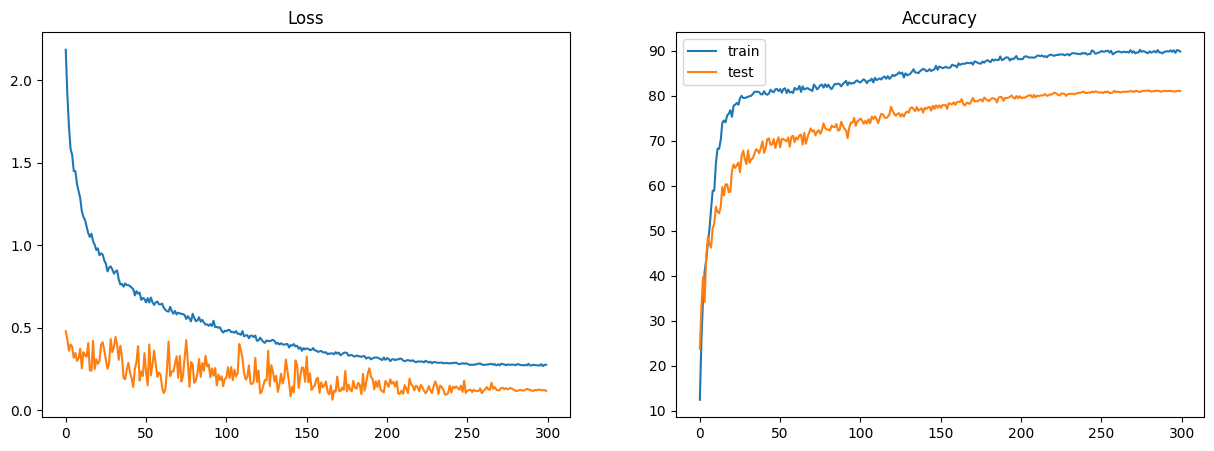

In [35]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_10, label="train")
ax1.plot(test_losses_10, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_10, label="train")
ax2.plot(test_accuracies_10, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_10_KMEANS.png")

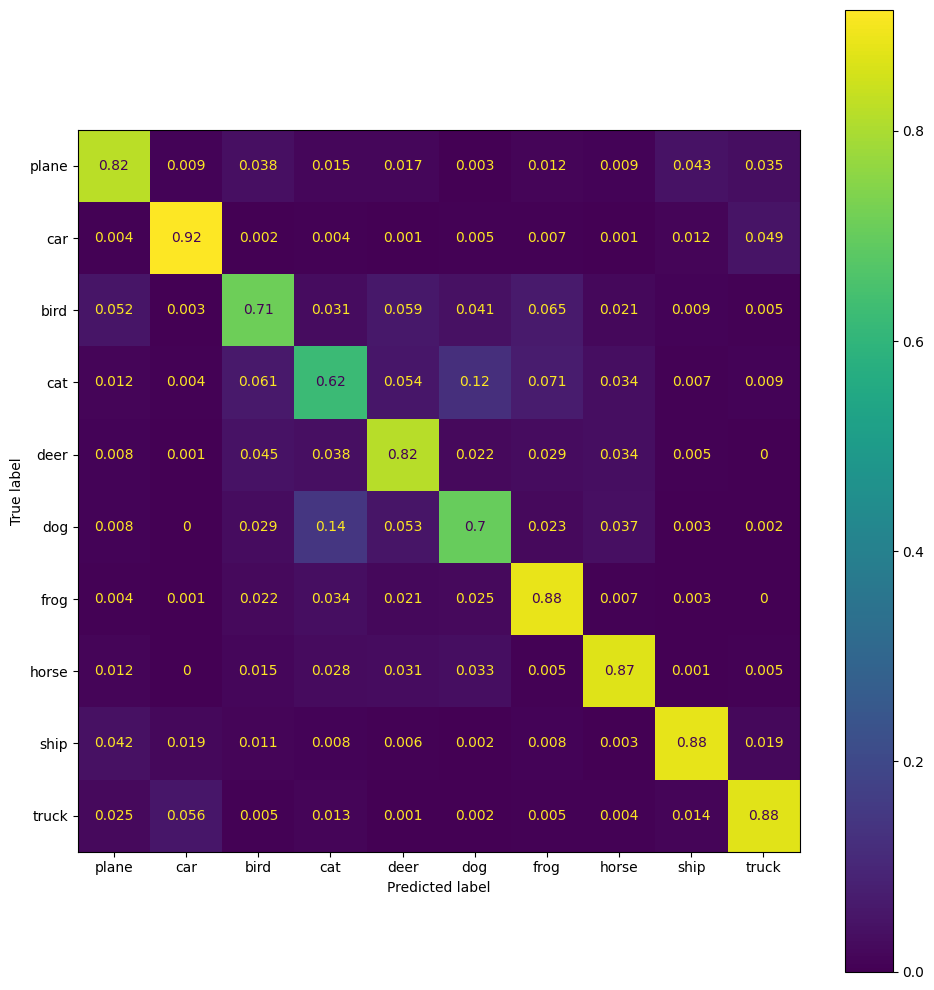

In [36]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_10(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_10_KMEANS.png")

Test Accuracy: 81.01%


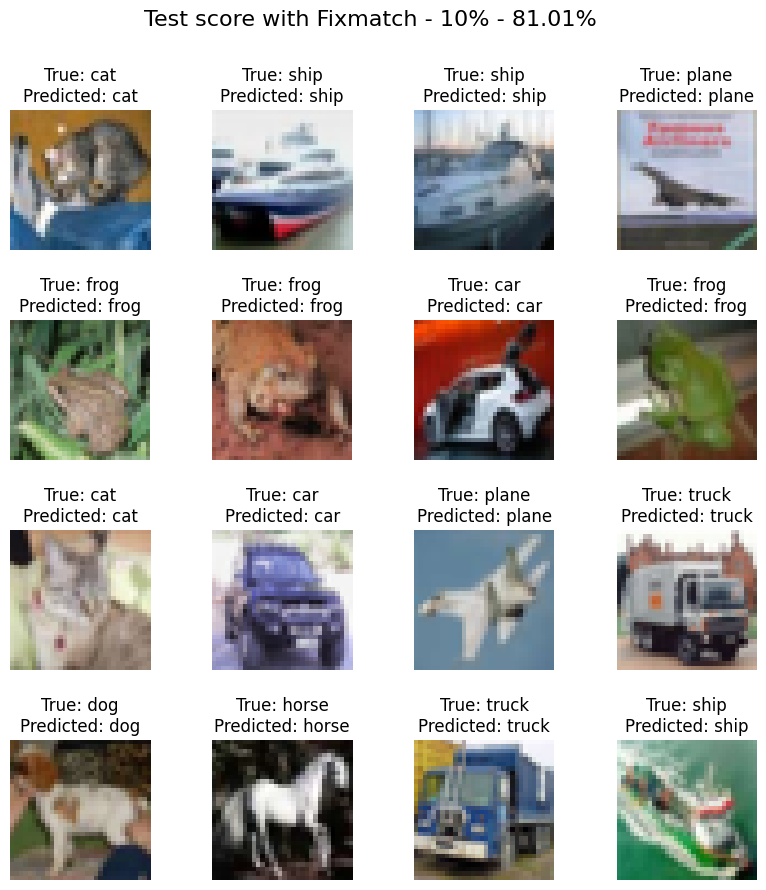

In [37]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_10(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_10_KMEANS.png")

### III.2 Fixmatch on 5% train data

Extracting embeddings from the model


  0%|          | 0/782 [00:00<?, ?it/s]

Performing KMeans clustering


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Computing cluster centers


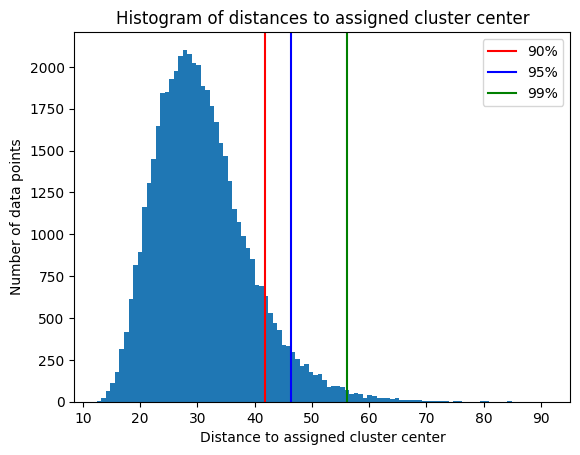

In [22]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.05

# load indices
indices_05 = perform_spectral_clustering(model_full, trainloader, budget=0.05)

In [23]:
trainset_sup = torch.utils.data.Subset(trainset, indices_05)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [24]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [25]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='05_KMEANS'
)

Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 18.93%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 25.3%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 23.87%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 32.53%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 34.3%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 34.61%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.86%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 43.56%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 43.67%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.24%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.99%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.32%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.39%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.43%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.21%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.93%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.41%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.04%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.66%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.02%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.6%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.0%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.58%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.67%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 54.59%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 55.29%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 52.73%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 53.75%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.43%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.81%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.53%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.75%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.64%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 56.5%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.13%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.72%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.87%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.41%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.1%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.91%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.8%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.57%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.52%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.36%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.56%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 58.71%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.67%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 57.53%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.15%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 59.59%


Epoch    50:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.07%


Epoch    51:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.18%


Epoch    52:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 61.34%


Epoch    53:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 60.39%


Epoch    54:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.65%


Epoch    55:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.07%


Epoch    56:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.61%


Epoch    57:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.34%


Epoch    58:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.52%


Epoch    59:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.75%


Epoch    60:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.54%


Epoch    61:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.96%


Epoch    62:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.98%


Epoch    63:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.21%


Epoch    64:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.75%


Epoch    65:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.23%


Epoch    66:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 62.4%


Epoch    67:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.25%


Epoch    68:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.1%


Epoch    69:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.92%


Epoch    70:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.33%


Epoch    71:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.89%


Epoch    72:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.44%


Epoch    73:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.34%


Epoch    74:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.81%


Epoch    75:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.26%


Epoch    76:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.92%


Epoch    77:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.02%


Epoch    78:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 63.82%


Epoch    79:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.97%


Epoch    80:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.51%


Epoch    81:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.41%


Epoch    82:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.04%


Epoch    83:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 65.51%


Epoch    84:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.17%


Epoch    85:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.68%


Epoch    86:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 64.98%


Epoch    87:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.92%


Epoch    88:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.17%


Epoch    89:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.59%


Epoch    90:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.86%


Epoch    91:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.88%


Epoch    92:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.37%


Epoch    93:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.7%


Epoch    94:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.97%


Epoch    95:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.41%


Epoch    96:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.62%


Epoch    97:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.9%


Epoch    98:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.46%


Epoch    99:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.48%


Epoch   100:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.67%


Epoch   101:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.57%


Epoch   102:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.38%


Epoch   103:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.53%


Epoch   104:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.36%


Epoch   105:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.25%


Epoch   106:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.92%


Epoch   107:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 66.67%


Epoch   108:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.76%


Epoch   109:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.6%


Epoch   110:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.83%


Epoch   111:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.02%


Epoch   112:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 67.89%


Epoch   113:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.64%


Epoch   114:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.38%


Epoch   115:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.56%


Epoch   116:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.5%


Epoch   117:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.7%


Epoch   118:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.86%


Epoch   119:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.43%


Epoch   120:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.35%


Epoch   121:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.79%


Epoch   122:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.74%


Epoch   123:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.14%


Epoch   124:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.15%


Epoch   125:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.17%


Epoch   126:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.52%


Epoch   127:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.14%


Epoch   128:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.64%


Epoch   129:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.74%


Epoch   130:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.86%


Epoch   131:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.42%


Epoch   132:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 68.7%


Epoch   133:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.25%


Epoch   134:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.77%


Epoch   135:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.05%


Epoch   136:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.73%


Epoch   137:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.56%


Epoch   138:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.9%


Epoch   139:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.82%


Epoch   140:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.01%


Epoch   141:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.23%


Epoch   142:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.1%


Epoch   143:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.74%


Epoch   144:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.51%


Epoch   145:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.99%


Epoch   146:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.54%


Epoch   147:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.42%


Epoch   148:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.9%


Epoch   149:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.33%


Epoch   150:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.34%


Epoch   151:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.47%


Epoch   152:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.43%


Epoch   153:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.83%


Epoch   154:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.98%


Epoch   155:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 69.92%


Epoch   156:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.05%


Epoch   157:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.12%


Epoch   158:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.42%


Epoch   159:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.62%


Epoch   160:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.44%


Epoch   161:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.49%


Epoch   162:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.04%


Epoch   163:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.78%


Epoch   164:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.79%


Epoch   165:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.79%


Epoch   166:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.48%


Epoch   167:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 70.93%


Epoch   168:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.5%


Epoch   169:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.27%


Epoch   170:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.49%


Epoch   171:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.16%


Epoch   172:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.67%


Epoch   173:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.02%


Epoch   174:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.87%


Epoch   175:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.79%


Epoch   176:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.79%


Epoch   177:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.1%


Epoch   178:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.86%


Epoch   179:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.64%


Epoch   180:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.23%


Epoch   181:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.52%


Epoch   182:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.4%


Epoch   183:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.74%


Epoch   184:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.86%


Epoch   185:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 71.85%


Epoch   186:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.36%


Epoch   187:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.75%


Epoch   188:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.58%


Epoch   189:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.63%


Epoch   190:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.33%


Epoch   191:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.98%


Epoch   192:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.75%


Epoch   193:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.02%


Epoch   194:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.21%


Epoch   195:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.32%


Epoch   196:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.14%


Epoch   197:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.35%


Epoch   198:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.15%


Epoch   199:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.28%


Epoch   200:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.09%


Epoch   201:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.43%


Epoch   202:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.65%


Epoch   203:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.62%


Epoch   204:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.77%


Epoch   205:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 72.94%


Epoch   206:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.17%


Epoch   207:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.61%


Epoch   208:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.48%


Epoch   209:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.69%


Epoch   210:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.65%


Epoch   211:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.64%


Epoch   212:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.83%


Epoch   213:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.48%


Epoch   214:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.43%


Epoch   215:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.35%


Epoch   216:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.5%


Epoch   217:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.38%


Epoch   218:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.31%


Epoch   219:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.82%


Epoch   220:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.77%


Epoch   221:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.67%


Epoch   222:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.63%


Epoch   223:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.27%


Epoch   224:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.82%


Epoch   225:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.85%


Epoch   226:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch   227:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.18%


Epoch   228:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.21%


Epoch   229:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.12%


Epoch   230:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.09%


Epoch   231:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.92%


Epoch   232:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.32%


Epoch   233:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.11%


Epoch   234:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.04%


Epoch   235:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.26%


Epoch   236:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.4%


Epoch   237:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 73.82%


Epoch   238:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.27%


Epoch   239:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.27%


Epoch   240:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.25%


Epoch   241:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.5%


Epoch   242:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.46%


Epoch   243:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.27%


Epoch   244:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch   245:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.23%


Epoch   246:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.47%


Epoch   247:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.24%


Epoch   248:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.28%


Epoch   249:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.35%


Epoch   250:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.25%


Epoch   251:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.25%


Epoch   252:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.17%


Epoch   253:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.24%


Epoch   254:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.13%


Epoch   255:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.31%


Epoch   256:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.18%


Epoch   257:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.23%


Epoch   258:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.38%


Epoch   259:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.45%


Epoch   260:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   261:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.33%


Epoch   262:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.53%


Epoch   263:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.44%


Epoch   264:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   265:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.34%


Epoch   266:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.63%


Epoch   267:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.57%


Epoch   268:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.43%


Epoch   269:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.44%


Epoch   270:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.7%


Epoch   271:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.63%


Epoch   272:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   273:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.74%


Epoch   274:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.47%


Epoch   275:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.49%


Epoch   276:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.43%


Epoch   277:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.59%


Epoch   278:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.45%


Epoch   279:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.47%


Epoch   280:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.52%


Epoch   281:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.72%


Epoch   282:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   283:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.51%


Epoch   284:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.58%


Epoch   285:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.4%


Epoch   286:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.52%


Epoch   287:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%


Epoch   288:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.47%


Epoch   289:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.56%


Epoch   290:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.63%


Epoch   291:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.55%


Epoch   292:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.57%


Epoch   293:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.55%


Epoch   294:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.6%


Epoch   295:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.66%


Epoch   296:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.56%


Epoch   297:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.61%


Epoch   298:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.55%


Epoch   299:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 74.54%
Finished Training


In [26]:
# open results
model_05 = ConvNN().to(device)
model_05.load_state_dict(torch.load('./results/models/model_05_KMEANS.pth'))
train_losses_05 = torch.load('./results/metrics/train_losses_05_KMEANS.pth')
train_accuracies_05 = torch.load('./results/metrics/train_accuracies_05_KMEANS.pth')
test_losses_05 = torch.load('./results/metrics/test_losses_05_KMEANS.pth')
test_accuracies_05 = torch.load('./results/metrics/test_accuracies_05_KMEANS.pth')

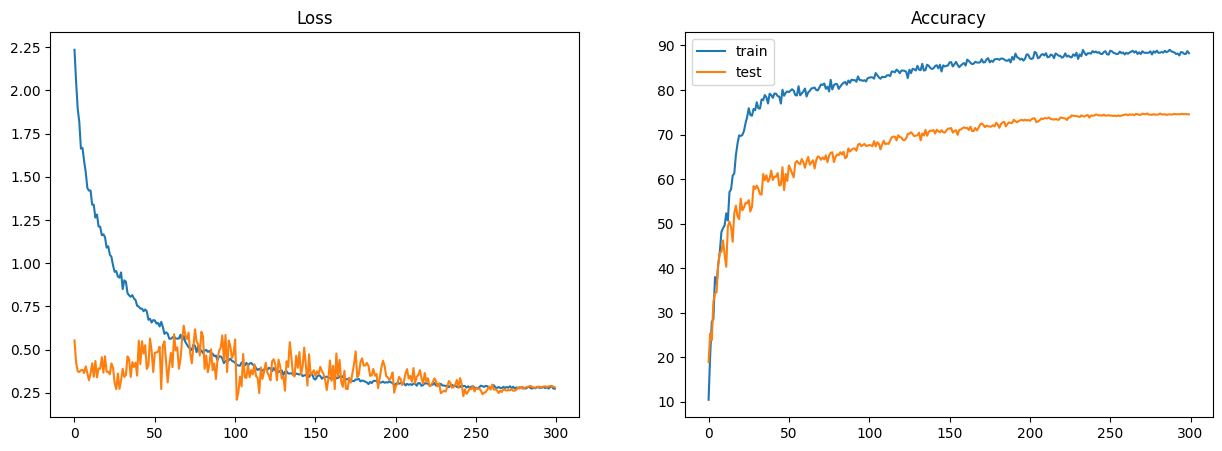

In [27]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_05, label="train")
ax1.plot(test_losses_05, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_05, label="train")
ax2.plot(test_accuracies_05, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_05_KMEANS.png")

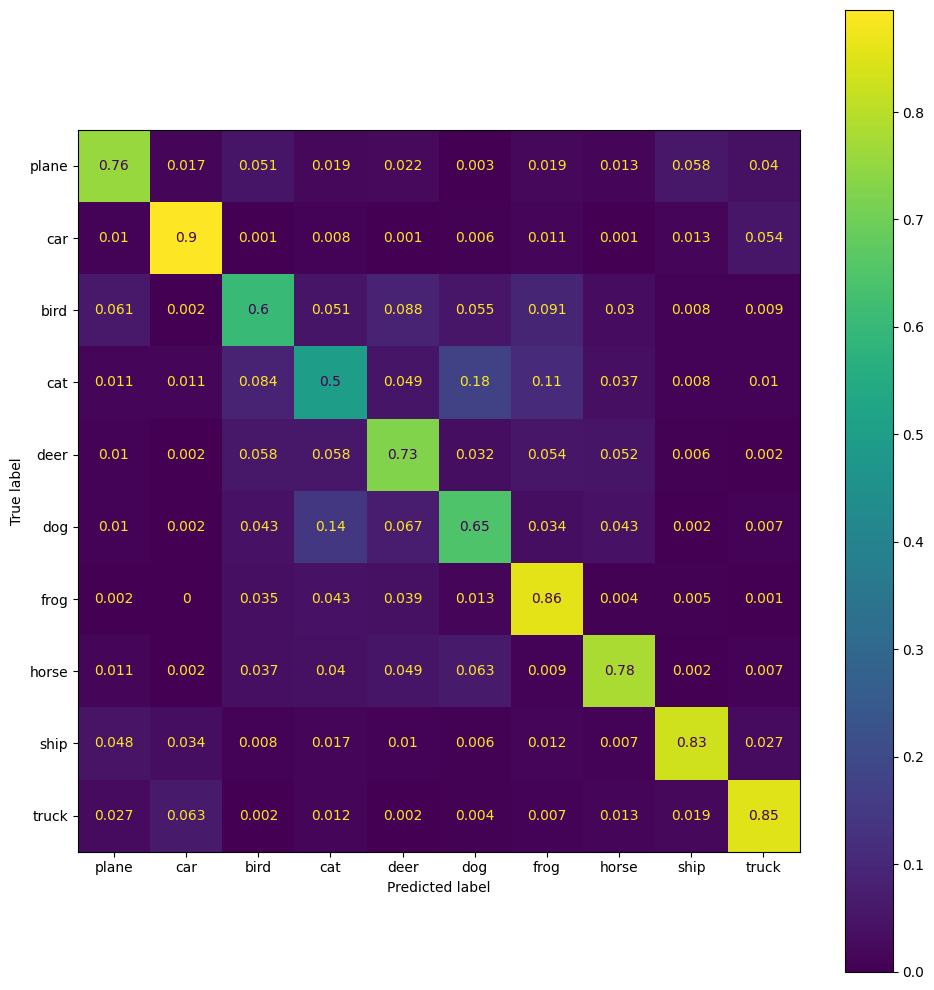

In [28]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_05(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_05_KMEANS.png")

Test Accuracy: 74.54%


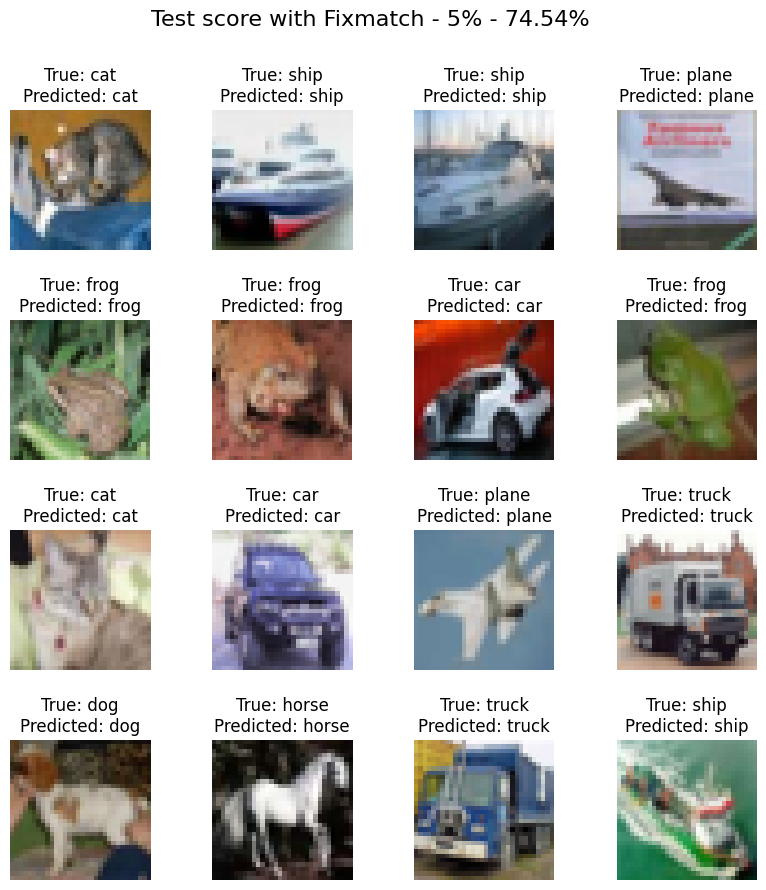

In [29]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_05(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_05_KMEANS.png")

### III.3 Fixmatch on 1% train data

Extracting embeddings from the model


  0%|          | 0/782 [00:00<?, ?it/s]

Performing KMeans clustering


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Computing cluster centers


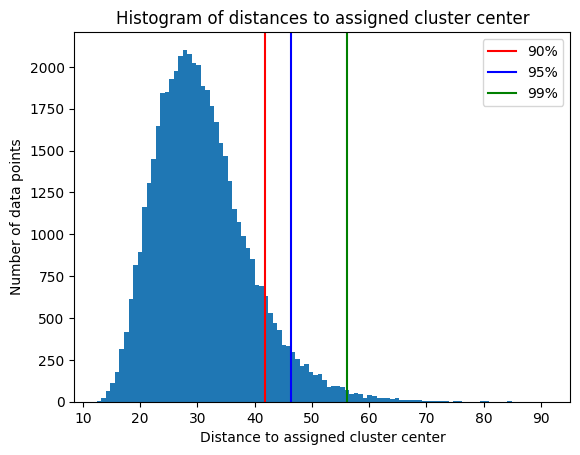

In [13]:
# fix the seed
seedEverything()

SUBSET_PROP = 0.01

# load indices
indices_01 = perform_spectral_clustering(model_full, trainloader, budget=0.01)

In [14]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [15]:
trainset_sup = torch.utils.data.Subset(trainset, indices_01)

trainset_unsup, _ = torch.utils.data.random_split(trainset, [1, 0])

labeled_dataloader = DataLoader(
    trainset_sup,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

unlabeled_dataloader = DataLoader(
    trainset_unsup,
    batch_size=MU*BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [16]:
EPOCHS = 300

model = ConvNN().to(device)

# criterion and optimizer
labeled_criterion = nn.CrossEntropyLoss(reduction='none')
unlabeled_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(labeled_dataloader) * EPOCHS, eta_min=1e-4)

In [17]:
fixmatch_train(
    model=model,
    labeled_dataloader=labeled_dataloader,
    unlabeled_dataloader=unlabeled_dataloader,
    testloader=testloader,
    labeled_criterion=labeled_criterion,
    unlabeled_criterion=unlabeled_criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    mean=mean,
    std=std,
    lambda_u=LAMBDA_U,
    tau=TAU,
    mu=MU,
    batch_size=BATCH_SIZE,
    name='01_KMEANS'
)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.28%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 16.47%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 17.04%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 19.68%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 22.18%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 22.75%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.25%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 27.07%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 26.86%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 23.68%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 28.4%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.33%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 29.19%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.31%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 32.48%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.49%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.26%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.81%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.97%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.09%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 35.35%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.56%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 33.82%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.1%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.2%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 36.94%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.74%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.88%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.22%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.46%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.71%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.77%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.04%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.42%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.77%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 37.82%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.42%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.01%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.66%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.5%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.15%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.72%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.26%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.43%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.81%


Epoch    50:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.87%


Epoch    51:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.85%


Epoch    52:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.96%


Epoch    53:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.31%


Epoch    54:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 30.29%


Epoch    55:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.9%


Epoch    56:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.63%


Epoch    57:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 38.83%


Epoch    58:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.47%


Epoch    59:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.83%


Epoch    60:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.91%


Epoch    61:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.37%


Epoch    62:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.41%


Epoch    63:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.82%


Epoch    64:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.83%


Epoch    65:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.46%


Epoch    66:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.56%


Epoch    67:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 40.8%


Epoch    68:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.08%


Epoch    69:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.19%


Epoch    70:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.68%


Epoch    71:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 39.35%


Epoch    72:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.11%


Epoch    73:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.17%


Epoch    74:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.05%


Epoch    75:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.68%


Epoch    76:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.78%


Epoch    77:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.69%


Epoch    78:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.81%


Epoch    79:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.55%


Epoch    80:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.63%


Epoch    81:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.49%


Epoch    82:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.27%


Epoch    83:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.84%


Epoch    84:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.19%


Epoch    85:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.1%


Epoch    86:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.96%


Epoch    87:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.5%


Epoch    88:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.76%


Epoch    89:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 41.36%


Epoch    90:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.07%


Epoch    91:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.48%


Epoch    92:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.72%


Epoch    93:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.87%


Epoch    94:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.47%


Epoch    95:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.15%


Epoch    96:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.0%


Epoch    97:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.13%


Epoch    98:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.67%


Epoch    99:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.93%


Epoch   100:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 42.6%


Epoch   101:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.49%


Epoch   102:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.23%


Epoch   103:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.56%


Epoch   104:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.9%


Epoch   105:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.44%


Epoch   106:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.87%


Epoch   107:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.3%


Epoch   108:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.03%


Epoch   109:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.15%


Epoch   110:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.57%


Epoch   111:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.9%


Epoch   112:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.79%


Epoch   113:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.55%


Epoch   114:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.56%


Epoch   115:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.78%


Epoch   116:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.78%


Epoch   117:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 43.76%


Epoch   118:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.96%


Epoch   119:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.6%


Epoch   120:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.66%


Epoch   121:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.18%


Epoch   122:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.04%


Epoch   123:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.2%


Epoch   124:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.0%


Epoch   125:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.09%


Epoch   126:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.83%


Epoch   127:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.63%


Epoch   128:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.53%


Epoch   129:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.27%


Epoch   130:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.31%


Epoch   131:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.51%


Epoch   132:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.15%


Epoch   133:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.54%


Epoch   134:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.7%


Epoch   135:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.51%


Epoch   136:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.6%


Epoch   137:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.53%


Epoch   138:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.11%


Epoch   139:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.83%


Epoch   140:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 44.86%


Epoch   141:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.16%


Epoch   142:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.34%


Epoch   143:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.31%


Epoch   144:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.85%


Epoch   145:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.28%


Epoch   146:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.12%


Epoch   147:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.71%


Epoch   148:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.61%


Epoch   149:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.18%


Epoch   150:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.45%


Epoch   151:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.32%


Epoch   152:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.55%


Epoch   153:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.98%


Epoch   154:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.65%


Epoch   155:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.12%


Epoch   156:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.01%


Epoch   157:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.45%


Epoch   158:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.27%


Epoch   159:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.39%


Epoch   160:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.02%


Epoch   161:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.41%


Epoch   162:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.94%


Epoch   163:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.65%


Epoch   164:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 45.59%


Epoch   165:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.16%


Epoch   166:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.45%


Epoch   167:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.48%


Epoch   168:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.0%


Epoch   169:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.17%


Epoch   170:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.4%


Epoch   171:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.21%


Epoch   172:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.74%


Epoch   173:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.39%


Epoch   174:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.4%


Epoch   175:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.8%


Epoch   176:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.31%


Epoch   177:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.58%


Epoch   178:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.18%


Epoch   179:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.04%


Epoch   180:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.28%


Epoch   181:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.77%


Epoch   182:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.93%


Epoch   183:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.37%


Epoch   184:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.84%


Epoch   185:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.16%


Epoch   186:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.89%


Epoch   187:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.68%


Epoch   188:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.44%


Epoch   189:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.23%


Epoch   190:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.24%


Epoch   191:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.92%


Epoch   192:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.56%


Epoch   193:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.93%


Epoch   194:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.71%


Epoch   195:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.21%


Epoch   196:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.58%


Epoch   197:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.39%


Epoch   198:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.65%


Epoch   199:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.23%


Epoch   200:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.49%


Epoch   201:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.46%


Epoch   202:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.12%


Epoch   203:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.48%


Epoch   204:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.75%


Epoch   205:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 46.91%


Epoch   206:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.74%


Epoch   207:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.11%


Epoch   208:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.96%


Epoch   209:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.35%


Epoch   210:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.41%


Epoch   211:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.03%


Epoch   212:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.29%


Epoch   213:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.08%


Epoch   214:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.82%


Epoch   215:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.66%


Epoch   216:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.71%


Epoch   217:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.07%


Epoch   218:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.25%


Epoch   219:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.78%


Epoch   220:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.78%


Epoch   221:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.71%


Epoch   222:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.2%


Epoch   223:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.95%


Epoch   224:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.01%


Epoch   225:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.05%


Epoch   226:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.87%


Epoch   227:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.13%


Epoch   228:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.11%


Epoch   229:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.11%


Epoch   230:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.24%


Epoch   231:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.72%


Epoch   232:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.04%


Epoch   233:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.34%


Epoch   234:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.09%


Epoch   235:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.95%


Epoch   236:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.93%


Epoch   237:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.73%


Epoch   238:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.04%


Epoch   239:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.82%


Epoch   240:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.72%


Epoch   241:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.85%


Epoch   242:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.6%


Epoch   243:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.95%


Epoch   244:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.96%


Epoch   245:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.86%


Epoch   246:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.78%


Epoch   247:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.85%


Epoch   248:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.19%


Epoch   249:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.47%


Epoch   250:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.45%


Epoch   251:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.07%


Epoch   252:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.89%


Epoch   253:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.81%


Epoch   254:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.88%


Epoch   255:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.75%


Epoch   256:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.65%


Epoch   257:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.61%


Epoch   258:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.68%


Epoch   259:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.72%


Epoch   260:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.85%


Epoch   261:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.74%


Epoch   262:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.7%


Epoch   263:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.8%


Epoch   264:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.87%


Epoch   265:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.94%


Epoch   266:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.82%


Epoch   267:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.88%


Epoch   268:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.74%


Epoch   269:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.66%


Epoch   270:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.75%


Epoch   271:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.73%


Epoch   272:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.86%


Epoch   273:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.92%


Epoch   274:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.97%


Epoch   275:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.94%


Epoch   276:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.02%


Epoch   277:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.01%


Epoch   278:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.03%


Epoch   279:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.99%


Epoch   280:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.97%


Epoch   281:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.99%


Epoch   282:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.01%


Epoch   283:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.93%


Epoch   284:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 48.0%


Epoch   285:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.98%


Epoch   286:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.9%


Epoch   287:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.88%


Epoch   288:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.89%


Epoch   289:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.94%


Epoch   290:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.87%


Epoch   291:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch   292:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.84%


Epoch   293:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.82%


Epoch   294:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.86%


Epoch   295:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.83%


Epoch   296:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.82%


Epoch   297:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.81%


Epoch   298:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.79%


Epoch   299:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 47.81%
Finished Training


In [18]:
# open results
model_01 = ConvNN().to(device)
model_01.load_state_dict(torch.load('./results/models/model_01_KMEANS.pth'))
train_losses_01 = torch.load('./results/metrics/train_losses_01_KMEANS.pth')
train_accuracies_01 = torch.load('./results/metrics/train_accuracies_01_KMEANS.pth')
test_losses_01 = torch.load('./results/metrics/test_losses_01_KMEANS.pth')
test_accuracies_01 = torch.load('./results/metrics/test_accuracies_01_KMEANS.pth')

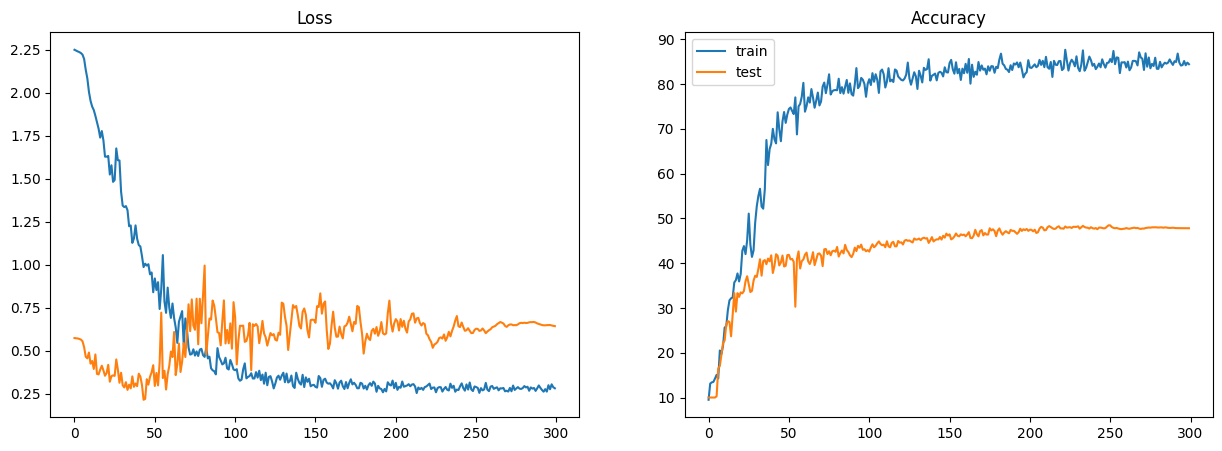

In [19]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_01, label="train")
ax1.plot(test_losses_01, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_01, label="train")
ax2.plot(test_accuracies_01, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_01_KMEANS.png")

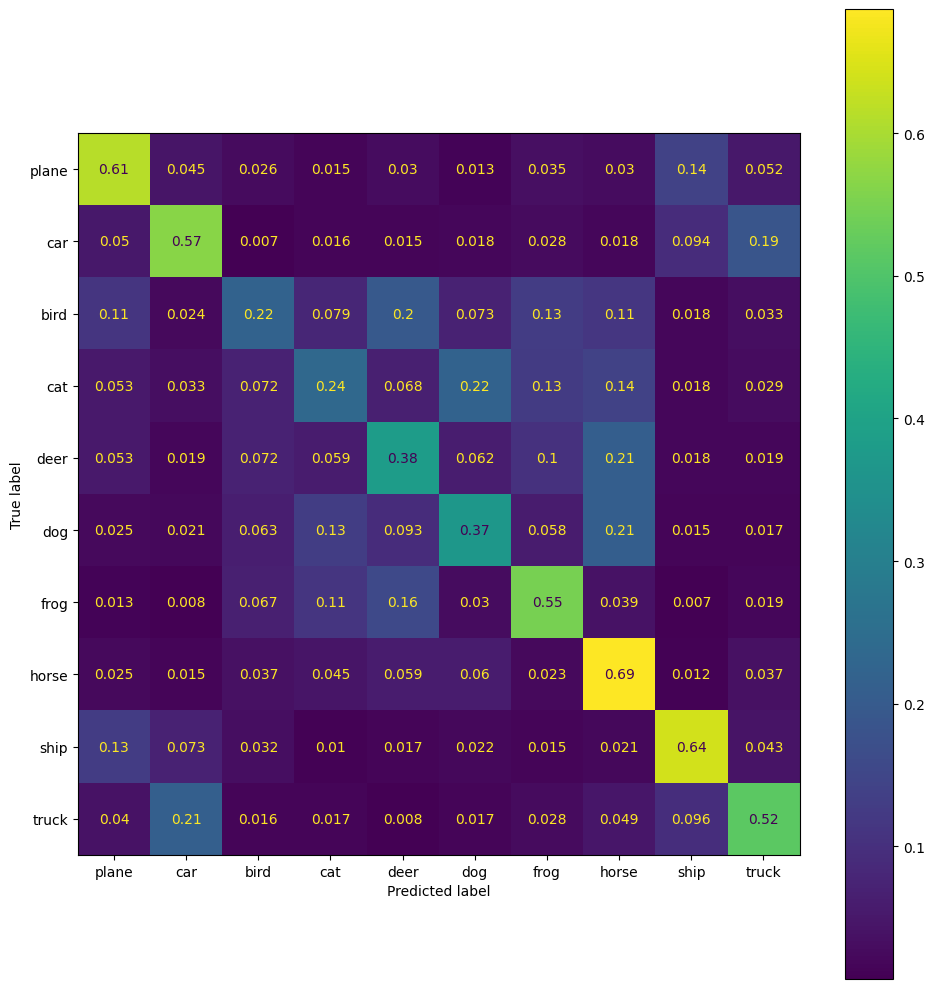

In [20]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_01(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_01_KMEANS.png")

Test Accuracy: 47.81%


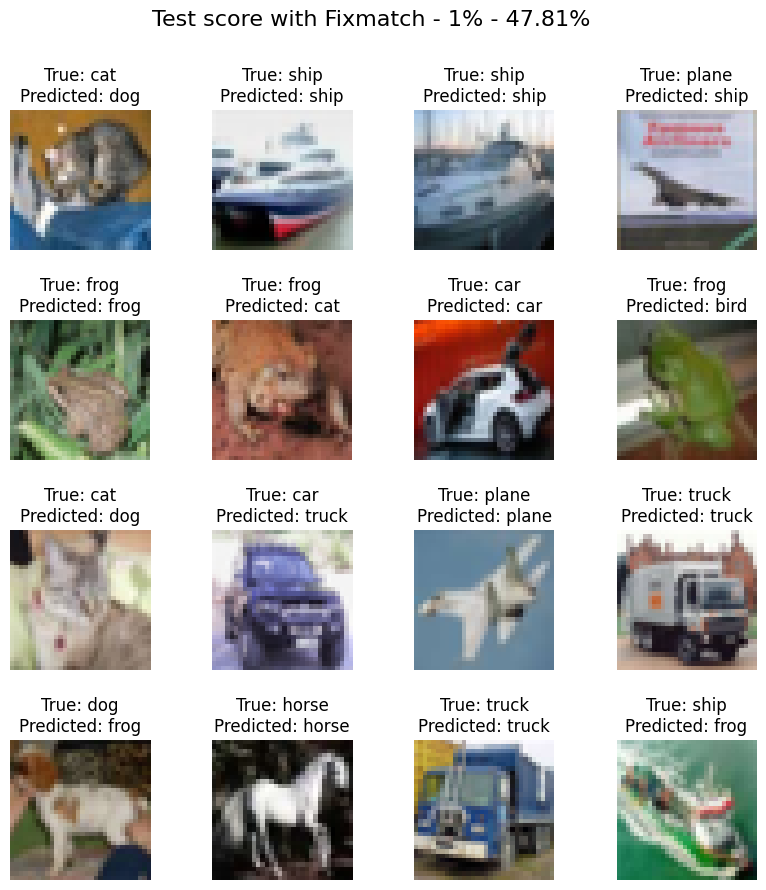

In [21]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_01(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score with Fixmatch - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_01_KMEANS.png")